In [1]:
from asset_model import *
asset_names = ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"]
Nsim = 10

### should be hidden functions

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm

inerest_rate_path = "../interest rate model/interest_rate_wh.csv"

time_format = "%Y-%m-%d"

interest_rate_date = "2022-07-26" # TODO: hard code, need to change when used

denomination = 5000
barrier = 0.59
# being the date on which the Strike and the Barrier and the Ratio is fixed,
# and from which date the Complex Products may be traded
initial_fixing_date = "2022-04-25" 
final_fixing_date = "2023-07-26"
final_redemption_date = "2023-08-02"

issue_date = "2022-05-02"

coupon_rate = 0.11 / 4

coupon_payment_dates = [
    "2022-08-02",
    "2022-11-02",
    "2023-02-02",
    "2023-05-02",
    "2023-08-02"
]

exercise_dates = [
    "2022-10-26",
    "2023-01-26",
    "2023-04-25"
]

early_redemption_dates = [
    "2022-11-02",
    "2023-02-02",
    "2023-05-02"
]

stock_init_price = {
    "GOOGL":  2461.48 / 20,
    "AAPL": 162.88,
    "MSFT": 280.72
}

stock_ratio = {
    "GOOGL":  40.62596486666558,
    "AAPL": 30.6974,
    "MSFT": 17.8113
}

stock_names = ["GOOGL",	"MSFT",	"AAPL"]



def get_business_days_from_initial_date(cur_date, initial_date = issue_date):
    return np.busday_count(initial_date, cur_date)

def get_business_days_to_final_redemption(cur_date, final_date = final_redemption_date):
    return np.busday_count(cur_date, final_date)

## dummy intesest rate func 
# (should return the average interest rate from current date to final redemption date)
def get_interest_rate(cur_date, to_date = final_redemption_date):
    try:
        r = float(interest_rate_df.loc[interest_rate_date, "rate"]) / 100
    except:
        day = pd.to_datetime(interest_rate_date) - pd.Timedelta(days = 1)
        r = float(interest_rate_df.loc[day, "rate"]) / 100
    ## TODO: return r
    return r

def get_discounted_price(p: float, cur_date, to_date = final_redemption_date):
    r = get_interest_rate(cur_date)
    return p * np.exp(- r * np.busday_count(cur_date, to_date) / 250)

## p_mature should be the lowest total price of stocks
def get_product_price(p_mature, cur_date, next_date = final_redemption_date):
    coupon_remaining = 0.0
    for coupon_payment_date in coupon_payment_dates:
        if cur_date <= coupon_payment_date and coupon_payment_date < next_date:
            coupon_remaining += get_discounted_price(denomination * coupon_rate, cur_date, coupon_payment_date)
    d = get_discounted_price(p_mature, cur_date, final_redemption_date)
    return d + coupon_remaining

## input: 
stock_names = ["GOOGL", "AAPL", "MSFT"]

def get_redemption_amount(df: pd.DataFrame):
    lowest_prices = df[stock_names].min()
    barrier_trigger = (lowest_prices / df_init_price < barrier).sum() 

    # if log:
    #     print("barrier_trigger", barrier_trigger)

    if barrier_trigger > 0:
        tmpdf = df.reset_index().set_index("date")
        stock_min = (tmpdf.loc[tmpdf.index.max(), stock_names] * df_convert).min()
        # if log:
        #     print("stock_min", stock_min)
        return min(stock_min, denomination)
    else:
        return denomination

## y = a_0 + a_1 * x + a_2 * x ** 2
class Poly2DModel:
    
    mod: sm.OLS
    x_name: str
    
    def fit(self, df : pd.DataFrame, x_names: list, y_name: str):
        self.x_names = x_names.copy()
        self.df = df
        for x_name in self.x_names:
            self.df[x_name + "_sq"] = np.power(self.df[x_name], 2)
        
        self.x_names.extend([x_name + "_sq" for x_name in self.x_names])
            
        self.X = sm.add_constant(self.df[self.x_names])
        self.y = self.df[y_name]
        self.mod = sm.OLS(self.y, self.X).fit()

    def predict(self):
        self.df["pred"] = self.mod.predict()
        return self.mod.predict()

def get_sim_noncallable_price(df: pd.DataFrame):
    func_df = df.set_index(["index", "date"])
    l = []
    for i in  range(Nsim):
        tmp_df = func_df.loc[i]
        l.append(get_product_price(get_redemption_amount(tmp_df), cur_date = final_redemption_date))
        
    return pd.Series(l, index = pd.Series([x for x in range(Nsim)]))

# input df: to get prices of underlying assets to run the regression
def get_v_backward(df: pd.DataFrame, exercise_date: str, redemption_date: str, v: pd.Series, v_date: str) -> pd.Series:
    discounted_v = v.apply(lambda x: get_discounted_price(x, redemption_date, v_date))
    mod = Poly2DModel()
    regress_input_df = (
        df.set_index(["date", "index"])
        .loc[exercise_date, stock_names]
    ).assign(discounted_v = discounted_v)

    mod.fit(regress_input_df, stock_names, "discounted_v")
    pred_v = mod.predict()

    return discounted_v.where((pred_v < denomination), other = denomination) + denomination * coupon_rate

interest_rate_df = pd.read_csv(inerest_rate_path, index_col = "Date")
df_init_price = pd.Series(stock_init_price)
df_convert = pd.Series(stock_ratio)



## Define suitable simulator

use "2022-07-01" as example (data until "2022-06-30")

In [3]:
class MultiAssetGBM_h(MultiAssetGBM):

    def update_price(self, stock_name: str, date, h: float):
        self.df.loc[date, stock_name] *= (1 + h/100)
        self.calculate_returns()

    def change_back_price(self, stock_name: str, date, h: float):
        self.df.loc[date, stock_name] /= (1 + h/100)
        self.calculate_returns()

    def calculate_returns(self):
        calculate_returns(self.df, asset_names)


### Simulate Delta using finate difference model

In [4]:
def get_v_0_series(price_change_asset, cur_date,  h):

    time_format = "%Y-%m-%d"
    try:
        cur_date = pd.to_datetime(cur_date, format = time_format)
    except:
        pass

    np.random.seed(4518)


    sample_cols = ["GOOGL", "MSFT", "AAPL"]
    fixing_date = "2023-07-26"
    asset_names = ["GOOGL UW Equity", "MSFT UW Equity", "AAPL UW Equity"]
    df = pd.read_csv("../stock_pricing/stock_historical_prices.csv")

    multassetGBM = MultiAssetGBM_h(df, fixing_date, asset_names)

    sample_start_date = cur_date + pd.Timedelta(days = 1)
    historical_data_start_date = (cur_date - pd.Timedelta(days = 365)).strftime(time_format)
    multassetGBM.set_start_date(historical_data_start_date)
    multassetGBM.update_price(price_change_asset, cur_date, h)
    samples = [pd.DataFrame(multassetGBM.get_path(cur_date.strftime(time_format)).transpose(), 
                columns = sample_cols, 
                index = pd.bdate_range(sample_start_date, fixing_date, name = "date")) for i in range(Nsim)]
    for i in range(Nsim):
        samples[i]["index"] = i
    samples_df = pd.concat(samples)
    multassetGBM.change_back_price(price_change_asset, cur_date, h)
    samples_df.to_csv("tmp.csv")

    df_init_price = pd.Series(stock_init_price)
    df_convert = pd.Series(stock_ratio)

    # print("1 done")

    cur_date = cur_date + pd.Timedelta(days = 1)
    sim_df = pd.read_csv("tmp.csv")

    v_date = final_redemption_date
    v_price = get_sim_noncallable_price(sim_df) + denomination * coupon_rate
    cur_date = sim_df.date.min()
    interest_rate_date = cur_date # TODO: hardcode (should be fine)
    # print("2 done")
    for i in range(len(exercise_dates) - 1, -1, -1):
        exercise_date = exercise_dates[i]
        if cur_date < exercise_date:
            redemption_date = early_redemption_dates[i]
            v_price = get_v_backward(sim_df, exercise_date, redemption_date, v_price, v_date)
            v_date = redemption_date
    # print("3 done")

    ## edge case: consider the first coupon paymeent
    if cur_date < coupon_payment_dates[0]:
        v_price = v_price.apply(lambda x: get_product_price(x, coupon_payment_dates[0], next_date= v_date))
        v_date = coupon_payment_dates[0]
    v_0_price = v_price.apply(lambda x: get_product_price(x, cur_date, next_date= v_date))
    # print("4 done")

    return v_0_price

In [5]:
price_change_asset = "GOOGL UW Equity"
cur_date = pd.to_datetime("2022-06-30")

In [6]:
h = 0.5

In [7]:
v_0_price_0 = get_v_0_series(price_change_asset,cur_date,  0)
v_0_price_minus = get_v_0_series(price_change_asset, cur_date, -h)
v_0_price_plus = get_v_0_series(price_change_asset,cur_date, h)

In [8]:
def get_delta(v_0_price_minus, v_0_price_plus, h):
    return (v_0_price_plus - v_0_price_minus).mean() / (2 * np.abs(h))

def get_gamma(v_0_price_minus, v_0_price_plus,v_0_price_0, h):
    return (v_0_price_plus - 2 * v_0_price_0 + v_0_price_minus).mean() / (np.abs(h) ** 2)


In [9]:
get_delta(v_0_price_minus, v_0_price_plus, h), get_gamma(v_0_price_minus, v_0_price_plus,v_0_price_0, h)

(20.416742445381214, -0.035475568419678895)

In [10]:
records = []
Nsim = 50
for d in tqdm(pd.bdate_range("2022-05-31", "2022-08-15")): # "2022-05-31", "2022-08-15", "2022-10-31"
    for price_change_asset in asset_names:
        v_0_price_0 = get_v_0_series(price_change_asset, d, 0)
        v_0_price_minus = get_v_0_series(price_change_asset, d,-h)
        v_0_price_plus = get_v_0_series(price_change_asset, d, h)

        records.append([price_change_asset, d, get_delta(v_0_price_minus, v_0_price_plus, h), get_gamma(v_0_price_minus, v_0_price_plus,v_0_price_0, h)])


100%|██████████| 55/55 [05:29<00:00,  5.99s/it]


In [15]:
df = pd.DataFrame(records, columns=["asset", "date", "delta", "gamma"]).fillna(method = "ffill")
df

,asset,date,delta,gamma
0,GOOGL UW Equity,2022-05-31,19.329981,0.111007
1,MSFT UW Equity,2022-05-31,-0.038481,0.000471
2,AAPL UW Equity,2022-05-31,-0.134776,0.001554
3,GOOGL UW Equity,2022-06-01,52.085973,-161.474439
4,MSFT UW Equity,2022-06-01,-0.001194,0.000012
...,...,...,...,...
160,MSFT UW Equity,2022-08-12,-0.137441,0.001670
161,AAPL UW Equity,2022-08-12,-0.046626,0.000566
162,GOOGL UW Equity,2022-08-15,14.517807,-2.917324
163,MSFT UW Equity,2022-08-15,-0.024816,0.000256


In [16]:
df

,asset,date,delta,gamma
0,GOOGL UW Equity,2022-05-31,19.329981,0.111007
1,MSFT UW Equity,2022-05-31,-0.038481,0.000471
2,AAPL UW Equity,2022-05-31,-0.134776,0.001554
3,GOOGL UW Equity,2022-06-01,52.085973,-161.474439
4,MSFT UW Equity,2022-06-01,-0.001194,0.000012
...,...,...,...,...
160,MSFT UW Equity,2022-08-12,-0.137441,0.001670
161,AAPL UW Equity,2022-08-12,-0.046626,0.000566
162,GOOGL UW Equity,2022-08-15,14.517807,-2.917324
163,MSFT UW Equity,2022-08-15,-0.024816,0.000256


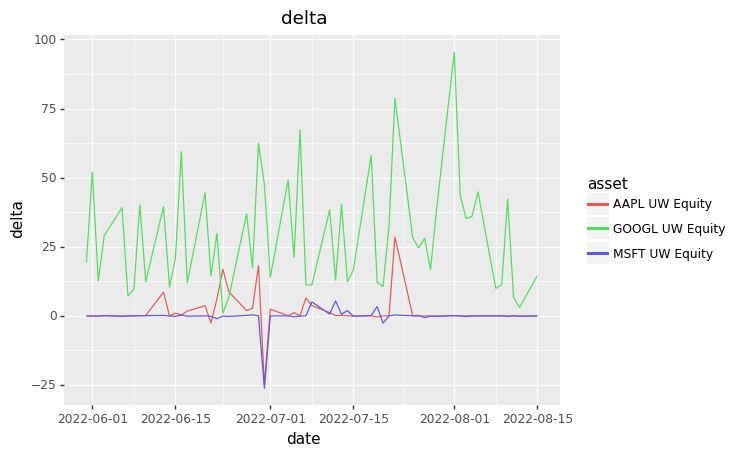

<ggplot: (165022056202)>

In [17]:
from plotnine import *
(
    ggplot()
    + geom_line(aes(x = "date", y = "delta", color = "asset"), show_legend = True, data = df)
    + labs(title = "delta")
)

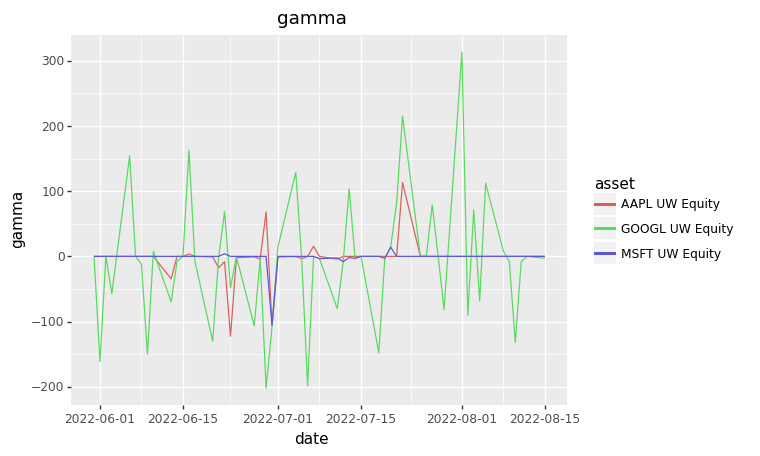

<ggplot: (165022073619)>

In [18]:
(
    ggplot()
    + geom_line(aes(x = "date", y = "gamma", color = "asset"),  data = df)
    + labs(title = "gamma")
    # + scale_y_log10()
)